# Load ROMS output using dask

Modified version of this example:

https://docs.xarray.dev/en/stable/examples/ROMS_ocean_model.html


# Dask worker setup instructions

https://github.com/mrayson/pawsey-containers/tree/master/hpc-python/jupyter-sfoda

Run each of the commands below in two (2) separate **notebook** terminals. These settings do the job:

 1. `dask-scheduler --scheduler-file scheduler-$HOSTNAME.json --idle-timeout 0`
 2. `ssh localhost "cd /software/projects/pawsey0106/mrayson/projects && sbatch --time=04:00:00 --ntasks=64 -c 2 start_worker.slm scheduler-$HOSTNAME.json ./"`


In [1]:
hostname = !echo $(hostname)
hostname[0]

'nid002536'

In [2]:
import os
from distributed import Client
client=Client(scheduler_file='../../scheduler-' + hostname[0] + '.json')
client

<Client: 'tcp://10.253.136.194:8786' processes=64 threads=128, memory=214.96 GiB>

In [3]:
import numpy as np
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import matplotlib.pyplot as plt

%matplotlib inline

import xarray as xr
from glob import glob

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ky16qs5z because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
# List our files with glob
ncfiles = sorted(glob('/scratch/pawsey0106/mrayson/WestCoastROMS/2020/*avg*.nc'))
ncfiles

['/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200101_12__avg.nc',
 '/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200102_12__avg.nc',
 '/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200103_12__avg.nc',
 '/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200104_12__avg.nc',
 '/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200105_12__avg.nc',
 '/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200106_12__avg.nc',
 '/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200107_12__avg.nc',
 '/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200108_12__avg.nc',
 '/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200109_12__avg.nc',
 '/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200110_12__avg.nc',
 '/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200111_12__avg.nc',
 '/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200112_12__avg.nc',
 '/scratch/pawsey0106/mrayson/WestCoastROMS/2020/cwa_20200113_12__avg.nc',
 '/scratch/pawsey0106/mra

In [5]:
# Let's load one file to have a look
ds = xr.open_dataset(ncfiles[0])
ds

<xarray.Dataset>
Dimensions:         (tracer: 2, s_rho: 25, s_w: 26, boundary: 4, ocean_time: 1,
                     eta_rho: 640, xi_rho: 480, eta_u: 640, xi_u: 479,
                     eta_v: 639, xi_v: 480)
Coordinates:
  * ocean_time      (ocean_time) datetime64[ns] 2020-01-01T12:00:00
  * s_rho           (s_rho) float64 -0.98 -0.94 -0.9 -0.86 ... -0.1 -0.06 -0.02
  * s_w             (s_w) float64 -1.0 -0.96 -0.92 -0.88 ... -0.08 -0.04 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v
Data variables: (12/94)
    Akk_bak         float64 ...
    Akp_bak         float64 ...
    Akt_bak         (tracer) float64 ...
    Akv_bak         float64 ...
    Charnok_alpha   float64 ...
    CrgBan_cw       float64 ...
    ...              ...
    v               (ocean_time, s_rho, eta_v, xi_v) float32 ...
    v_northward     (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    vbar            (ocean_time, eta_v, xi_v) float32 ...
    vbar_northward  (ocean_time, eta_rho, xi_rho) float32 ...
    xl              float64 ...
    zeta            (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/36)
    file:              ./outputs/cwa_avg_0001.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Central West Australia ROMS
    var_info:          varinfo.dat
    ...                ...
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3
    tiling:            012x016
    history:           Thu Mar  3 08:48:49 2022: ncks -7 --ppc zeta,ubar,ubar...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       cwa, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASS...
    NCO:               netCDF Operators version 4.7.6 (Homepage = http://nco....

In [6]:
# Load the grid and merge it's properties
grd = xr.open_dataset('/scratch/pawsey0106/mrayson/WestCoastROMS/grid.nc')
#xr.merge([grd,ds],compat='override').set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

In [7]:
# Open the multifile object (drop variables that we don't need for faster merging)

# Find the variables to drop
# (THere has to be a more elegant way of doing this...)
ds=xr.open_dataset(ncfiles[0])
keep_vars = ['temp','zeta','Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform']
my_vars=[]
all_vars=[]
for ff in ds.keys():
    all_vars.append(ff)
    for kk in keep_vars:
        if kk in ff:
            my_vars.append(ff)
            #print( ff, type(ff))

drop_vars = set(all_vars).difference(set(my_vars))
# drop_vars

In [8]:
%%time
dsall = xr.open_mfdataset(ncfiles, 
                          drop_variables=drop_vars,
                         parallel=True)

CPU times: user 1min 7s, sys: 8.49 s, total: 1min 15s
Wall time: 1min 34s


In [9]:
dsall

<xarray.Dataset>
Dimensions:         (ocean_time: 366, s_rho: 25, s_w: 26, eta_rho: 640,
                     xi_rho: 480)
Coordinates:
  * ocean_time      (ocean_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-...
  * s_rho           (s_rho) float64 -0.98 -0.94 -0.9 -0.86 ... -0.1 -0.06 -0.02
  * s_w             (s_w) float64 -1.0 -0.96 -0.92 -0.88 ... -0.08 -0.04 0.0
Dimensions without coordinates: eta_rho, xi_rho
Data variables: (12/19)
    Charnok_alpha   (ocean_time) float64 1.4e+03 1.4e+03 ... 1.4e+03 1.4e+03
    Cs_r            (ocean_time, s_rho) float64 dask.array<chunksize=(1, 25), meta=np.ndarray>
    Cs_w            (ocean_time, s_w) float64 dask.array<chunksize=(1, 26), meta=np.ndarray>
    Falpha          (ocean_time) float64 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    LsshCLM         (ocean_time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    Vstretching     (ocean_time) int32 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2
    ...              ...
    temp            (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 25, 640, 480), meta=np.ndarray>
    theta_b         (ocean_time) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    theta_s         (ocean_time) float64 7.0 7.0 7.0 7.0 7.0 ... 7.0 7.0 7.0 7.0
    v_northward     (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 25, 640, 480), meta=np.ndarray>
    vbar_northward  (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 640, 480), meta=np.ndarray>
    zeta            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 640, 480), meta=np.ndarray>
Attributes: (12/36)
    file:              ./outputs/cwa_avg_0001.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Central West Australia ROMS
    var_info:          varinfo.dat
    ...                ...
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3
    tiling:            012x016
    history:           Thu Mar  3 08:48:49 2022: ncks -7 --ppc zeta,ubar,ubar...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       cwa, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ASS...
    NCO:               netCDF Operators version 4.7.6 (Homepage = http://nco....

In [10]:
# Merge the grid variables
myds = xr.merge([grd,dsall],compat='override').set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
myds

<xarray.Dataset>
Dimensions:         (s_rho: 38, s_w: 33, eta_rho: 640, xi_rho: 480, bath: 1,
                     eta_u: 640, xi_u: 479, eta_v: 639, xi_v: 480,
                     eta_psi: 639, xi_psi: 479, eta_vert: 641, xi_vert: 481,
                     ocean_time: 366)
Coordinates:
  * s_rho           (s_rho) float64 -0.98 -0.94 -0.94 -0.9 ... -0.06 -0.02 -0.02
  * s_w             (s_w) float64 -1.0 -0.96 -0.92 -0.88 ... -0.04 -0.04 0.0
    hc              float64 ...
    Cs_r            (s_rho) float64 -0.9764 nan -0.9091 ... -2.656e-05 nan
    Cs_w            (s_w) float64 -1.0 -0.9454 -0.869 ... -0.0001409 nan 0.0
    h               (eta_rho, xi_rho) float64 ...
    lon_rho         (eta_rho, xi_rho) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    Vtransform      int32 ...
  * ocean_time      (ocean_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-...
Dimensions without coordinates: eta_rho, xi_rho, bath, eta_u, xi_u, eta_v,
                                xi_v, eta_psi, xi_psi, eta_vert, xi_vert
Data variables: (12/50)
    theta_s         float64 ...
    theta_b         float64 ...
    Tcline          float64 ...
    hraw            (bath, eta_rho, xi_rho) float64 ...
    f               (eta_rho, xi_rho) float64 ...
    pm              (eta_rho, xi_rho) float64 ...
    ...              ...
    shflux          (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 640, 480), meta=np.ndarray>
    sz_alpha        (ocean_time) float64 0.25 0.25 0.25 0.25 ... 0.25 0.25 0.25
    temp            (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 38, 640, 480), meta=np.ndarray>
    v_northward     (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 38, 640, 480), meta=np.ndarray>
    vbar_northward  (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 640, 480), meta=np.ndarray>
    zeta            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 640, 480), meta=np.ndarray>
Attributes:
    Description:  ROMS grid
    Author:       pyroms.grid.write_grd
    Created:      2015-06-18T10:36:55.766150
    type:         ROMS grid file
    sponge:       27-Oct-2016 created with /home/ivica/MODELS/ROMS/ver_3.6/Ma...

In [11]:
ds = myds
if ds.Vtransform == 1:
    Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
    z_rho = Zo_rho + ds.zeta * (1 + Zo_rho / ds.h)
elif ds.Vtransform == 2:
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho

ds.coords["z_rho"] = z_rho.transpose()  # needing transpose seems to be an xarray bug
ds.temp

<xarray.DataArray 'temp' (ocean_time: 366, s_rho: 38, eta_rho: 640, xi_rho: 480)>
dask.array<where, shape=(366, 38, 640, 480), dtype=float32, chunksize=(1, 38, 640, 480), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.98 -0.94 -0.94 -0.9 ... -0.06 -0.02 -0.02
    hc          float64 200.0
    Cs_r        (s_rho) float64 -0.9764 nan -0.9091 ... -2.656e-05 nan
    h           (xi_rho, eta_rho) float64 5.019e+03 5.019e+03 ... 2.0 2.0
    lon_rho     (xi_rho, eta_rho) float64 108.5 108.5 108.5 ... 113.9 113.8
    lat_rho     (xi_rho, eta_rho) float64 -34.33 -34.31 -34.29 ... -22.58 -22.57
    Vtransform  int32 2
  * ocean_time  (ocean_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-3...
    z_rho       (s_rho, xi_rho, eta_rho, ocean_time) float64 dask.array<chunksize=(38, 480, 640, 1), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:    time-averaged potential temperature
    units:        Celsius
    time:         ocean_time
    grid:         grid
    location:     face
    coordinates:  lon_rho lat_rho s_rho ocean_time
    field:        temperature, scalar, series

/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 89.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


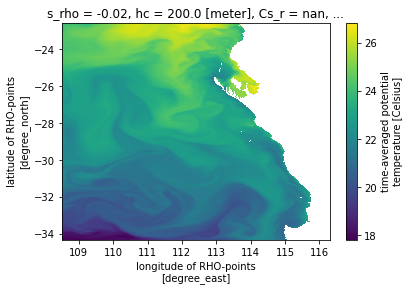

In [12]:
ds.temp.isel(s_rho=-1, ocean_time=0).plot(x="lon_rho", y="lat_rho")

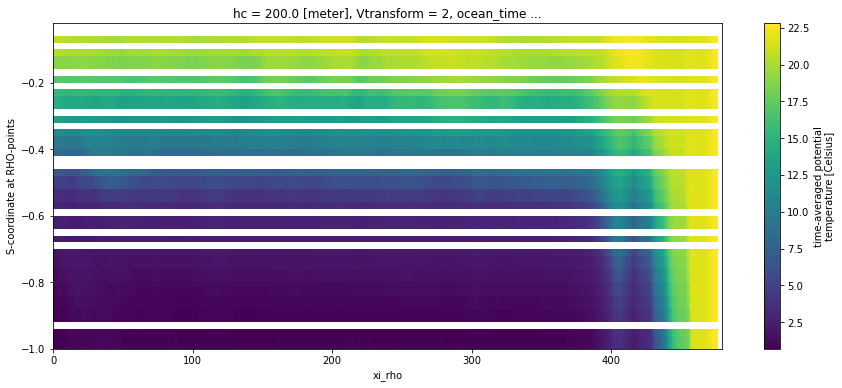

In [13]:
section = ds.temp.isel(eta_rho=100, ocean_time=0)
# section.plot(x="lon_rho", y="z_rho", figsize=(15, 6), clim=(10, 35))
section.plot( figsize=(15, 6), clim=(10, 35))

# plt.ylim([-100, 1]);

In [14]:
# Compute monthly mean sst
sst = ds.temp.isel(s_rho=-1)
sst_mean = sst.groupby("ocean_time.month").mean("ocean_time")
sst_mean

<xarray.DataArray 'temp' (month: 12, eta_rho: 640, xi_rho: 480)>
dask.array<stack, shape=(12, 640, 480), dtype=float32, chunksize=(1, 640, 480), chunktype=numpy.ndarray>
Coordinates:
    s_rho       float64 -0.02
    hc          float64 200.0
    Cs_r        float64 nan
    h           (xi_rho, eta_rho) float64 5.019e+03 5.019e+03 ... 2.0 2.0
    lon_rho     (xi_rho, eta_rho) float64 108.5 108.5 108.5 ... 113.9 113.8
    lat_rho     (xi_rho, eta_rho) float64 -34.33 -34.31 -34.29 ... -22.58 -22.57
    Vtransform  int32 2
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:    time-averaged potential temperature
    units:        Celsius
    time:         ocean_time
    grid:         grid
    location:     face
    coordinates:  lon_rho lat_rho s_rho ocean_time
    field:        temperature, scalar, series

In [15]:
import cmocean

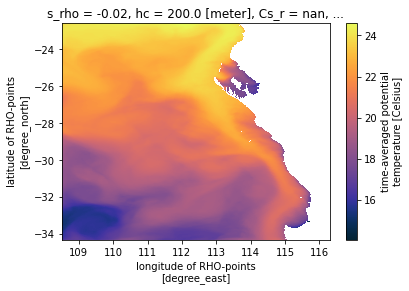

In [16]:
# PLot (Ths computes the values)
sst_mean.isel(month=6).plot(x="lon_rho", y="lat_rho", cmap='cmo.thermal')

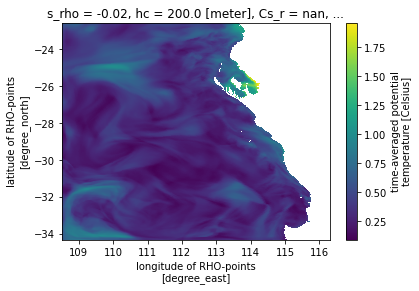

In [17]:
sst_std= sst.groupby("ocean_time.month").std("ocean_time")
sst_std.isel(month=0).plot(x="lon_rho", y="lat_rho")

In [18]:
temp_mean = ds['temp'].groupby("ocean_time.month").mean("ocean_time")
temp_mean

<xarray.DataArray 'temp' (month: 12, s_rho: 38, eta_rho: 640, xi_rho: 480)>
dask.array<stack, shape=(12, 38, 640, 480), dtype=float32, chunksize=(1, 38, 640, 480), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.98 -0.94 -0.94 -0.9 ... -0.06 -0.02 -0.02
    hc          float64 200.0
    Cs_r        (s_rho) float64 -0.9764 nan -0.9091 ... -2.656e-05 nan
    h           (xi_rho, eta_rho) float64 5.019e+03 5.019e+03 ... 2.0 2.0
    lon_rho     (xi_rho, eta_rho) float64 108.5 108.5 108.5 ... 113.9 113.8
    lat_rho     (xi_rho, eta_rho) float64 -34.33 -34.31 -34.29 ... -22.58 -22.57
    Vtransform  int32 2
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:    time-averaged potential temperature
    units:        Celsius
    time:         ocean_time
    grid:         grid
    location:     face
    coordinates:  lon_rho lat_rho s_rho ocean_time
    field:        temperature, scalar, series

In [19]:
%%time 
temp_mean.compute()

CPU times: user 175 ms, sys: 129 ms, total: 304 ms
Wall time: 4.34 s


<xarray.DataArray 'temp' (month: 12, s_rho: 38, eta_rho: 640, xi_rho: 480)>
array([[[[ 0.6497291 ,  0.64878404,  0.67253655, ...,         nan,
                  nan,         nan],
         [ 0.65073717,  0.69109124,  0.72108114, ...,         nan,
                  nan,         nan],
         [ 0.6533203 ,  0.7018334 ,  0.7430695 , ...,         nan,
                  nan,         nan],
         ...,
         [ 0.83499247,  0.8449471 ,  0.8456086 , ...,         nan,
                  nan,         nan],
         [ 0.8239982 ,  0.83379537,  0.8340159 , ...,         nan,
                  nan,         nan],
         [ 0.8246283 ,  0.82522684,  0.82267517, ...,         nan,
                  nan,         nan]],

        [[ 0.6848223 ,  0.6850113 ,  0.69509196, ...,         nan,
                  nan,         nan],
         [ 0.6846333 ,  0.7000378 ,  0.73434347, ...,         nan,
                  nan,         nan],
         [ 0.6970136 ,  0.7413055 ,  0.8093813 , ...,         nan,
                  nan,         nan],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[16.352318  , 16.342144  , 16.344223  , ...,         nan,
                  nan,         nan],
         [16.362494  , 16.327778  , 16.346838  , ...,         nan,
                  nan,         nan],
         [16.364698  , 16.344316  , 16.356382  , ...,         nan,
                  nan,         nan],
         ...,
         [24.09312   , 24.10802   , 24.12374   , ...,         nan,
                  nan,         nan],
         [24.085213  , 24.098097  , 24.11596   , ...,         nan,
                  nan,         nan],
         [24.090662  , 24.095924  , 24.110037  , ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
  * s_rho       (s_rho) float64 -0.98 -0.94 -0.94 -0.9 ... -0.06 -0.02 -0.02
    hc          float64 200.0
    Cs_r        (s_rho) float64 -0.9764 nan -0.9091 ... -2.656e-05 nan
    h           (xi_rho, eta_rho) float64 5.019e+03 5.019e+03 ... 2.0 2.0
    lon_rho     (xi_rho, eta_rho) float64 108.5 108.5 108.5 ... 113.9 113.8
    lat_rho     (xi_rho, eta_rho) float64 -34.33 -34.31 -34.29 ... -22.58 -22.57
    Vtransform  int32 2
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:    time-averaged potential temperature
    units:        Celsius
    time:         ocean_time
    grid:         grid
    location:     face
    coordinates:  lon_rho lat_rho s_rho ocean_time
    field:        temperature, scalar, series